# Калибровка полученных моделей

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, brier_score_loss, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.impute import KNNImputer
from sklearn.calibration import CalibratedClassifierCV

from keras.layers import Dense, Flatten
from keras import Sequential
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.utils import to_categorical
from keras import metrics

from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, XGBRFClassifier

import os
import warnings
warnings.filterwarnings('ignore')

# mlflow.sklearn.autolog()
# import mlflow

___Загрузка необходимых данных___

In [2]:
# Загрузка данных
df_train = pd.read_csv('data/train_data_processed.csv')
df_test = pd.read_csv('data/test_data_processed.csv')
df_valid = pd.read_csv('data/valid_data_processed.csv')

In [3]:
# Подгружаем модели

with open('models/model_xgb.pkl', 'rb') as f:
    model_xgb = pickle.load(f)
with open('models/model_lgb.pkl', 'rb') as f:
    model_lgb = pickle.load(f)
with open('models/model_rf.pkl', 'rb') as f:
    model_rf = pickle.load(f)
with open('models/model_log.pkl', 'rb') as f:
    model_log = pickle.load(f)

models_nn = []
for i in range(7):
    models_nn.append(load_model(f'models/model_nn_{i}.h5'))

models_all = [model_xgb, model_lgb, model_rf, model_log] + models_nn

In [4]:
# Загружаем датасет с метриками

df_metrics = pd.read_csv('data/metrics_all.csv')
df_metrics = df_metrics.set_index('Unnamed: 0')

In [5]:
# Назначим имена моделям
names = ['model_xgb', 'model_lgb', 'model_rf', 'model_log',
         'model_nn_0', 'model_nn_1', 'model_nn_2', 'model_nn_3', 'model_nn_4',
         'model_nn_5', 'model_nn_6',
        ]

In [6]:
# Будем использовать valid датасет в качестве калибровочного
df_valid = pd.read_csv('data/valid_data_processed.csv')

In [7]:
feature_columns = [
    'Client_age', 'Gender', 'Numb_of_Prod', 'Salary',
    'HasCrCard', 'Numb_of_years', 'CreditScore', 'Balance', 'IsActiveMember',
]
target_col = 'res'

## Калибровка моделей методом Плата

In [8]:
# Получаем колонки со скорами каждой модели на валидационном датасете
# (получаем вероятности принадлежности объектов к классу)

for i, model in enumerate(models_all):
    if not isinstance(model, Sequential): #смотрим это нейронка или нет (если нет)
        df_valid[f'{names[i]}_score'] = model.predict_proba(df_valid[feature_columns])[:,1]
    else:
        df_valid[f'{names[i]}_score'] = model.predict(df_valid[feature_columns])[:,1]

95/95 [==============================] - 0s 2ms/step


In [9]:
df_valid.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'res', 'Client_age', 'Gender',
       'Numb_of_Prod', 'Salary', 'HasCrCard', 'Numb_of_years', 'CreditScore',
       'Balance', 'IsActiveMember', 'model_xgb_score', 'model_lgb_score',
       'model_rf_score', 'model_log_score', 'model_nn_0_score',
       'model_nn_1_score', 'model_nn_2_score', 'model_nn_3_score',
       'model_nn_4_score', 'model_nn_5_score', 'model_nn_6_score'],
      dtype='object')

In [10]:
# Обучаем калибраторы Плата

calibrators = []
for i, model in enumerate(models_all):
    calibrator = LogisticRegression()
    calibrator.fit(pd.DataFrame(df_valid[f'{names[i]}_score']), df_valid[target_col])
    calibrators.append(calibrator)

__Тестирование откалиброванных моделей__

In [11]:
# Сначала создаем колонки со скорами всех моделей на train и test

for i, model in enumerate(models_all):
    if not isinstance(model, Sequential):
        df_train[f'{names[i]}_score'] = model.predict_proba(df_train[feature_columns])[:,1]
    else:
        df_train[f'{names[i]}_score'] = model.predict(df_train[feature_columns])[:,1]

for i, model in enumerate(models_all):
    if not isinstance(model, Sequential):
        df_test[f'{names[i]}_score'] = model.predict_proba(df_test[feature_columns])[:,1]
    else:
        df_test[f'{names[i]}_score'] = model.predict(df_test[feature_columns])[:,1]

158/158 [==============================] - 0s 2ms/step


In [12]:
df_metrics.head()

,Train_loss,Valid_loss,Test_loss,Train_accuracy,Valid_accuracy,Test_accuracy,Train_AUC,Valid_AUC,Test_AUC
Unnamed: 0,,,,,,,,,
model_0,0.209,0.919,0.973,0.213,0.914,0.972,0.210,0.922,0.973
model_1,0.231,0.909,0.968,0.239,0.905,0.967,0.225,0.913,0.969
model_2,0.216,0.921,0.971,0.214,0.923,0.972,0.226,0.919,0.969
model_3,0.399,0.876,0.881,0.408,0.873,0.879,0.391,0.880,0.883
model_4,0.297,0.894,0.932,0.304,0.890,0.929,0.297,0.895,0.931


In [13]:
# Сохранение датафреймов со скорами всех моделей

df_train.to_csv('data/train_data_with_scores')
df_valid.to_csv('data/valid_data_with_scores')
df_test.to_csv('data/test_data_with_scores')

In [14]:
# Подсчитываем метрики калибраторов и добавляем в датафрейм

for i, calibrator in enumerate(calibrators):

    preds_train = calibrator.predict_proba(pd.DataFrame(df_train[f'{names[i]}_score']))[:,1]
    preds_valid = calibrator.predict_proba(pd.DataFrame(df_valid[f'{names[i]}_score']))[:,1]
    preds_test = calibrator.predict_proba(pd.DataFrame(df_test[f'{names[i]}_score']))[:,1]

    labels_train = calibrator.predict(pd.DataFrame(df_train[f'{names[i]}_score']))
    labels_valid = calibrator.predict(pd.DataFrame(df_valid[f'{names[i]}_score']))
    labels_test = calibrator.predict(pd.DataFrame(df_test[f'{names[i]}_score']))

    row = [
        #f'{names[i]}_calibrated',
        log_loss(df_train[target_col], preds_train),
        log_loss(df_valid[target_col], preds_valid),
        log_loss(df_test[target_col], preds_test),
        accuracy_score(df_train[target_col], labels_train),
        accuracy_score(df_valid[target_col], labels_valid),
        accuracy_score(df_test[target_col], labels_test),
        roc_auc_score(df_train[target_col], preds_train),
        roc_auc_score(df_valid[target_col], preds_valid),
        roc_auc_score(df_test[target_col], preds_test),
    ]
    row = [round(j, 3) if j is not None and type(j) != str else j for j in row]

    df_metrics.loc[f'{names[i]}_calibrated'] = row

In [15]:
df_metrics

,Train_loss,Valid_loss,Test_loss,Train_accuracy,Valid_accuracy,Test_accuracy,Train_AUC,Valid_AUC,Test_AUC
Unnamed: 0,,,,,,,,,
model_0,0.209,0.919,0.973,0.213,0.914,0.972,0.210,0.922,0.973
model_1,0.231,0.909,0.968,0.239,0.905,0.967,0.225,0.913,0.969
model_2,0.216,0.921,0.971,0.214,0.923,0.972,0.226,0.919,0.969
model_3,0.399,0.876,0.881,0.408,0.873,0.879,0.391,0.880,0.883
model_4,0.297,0.894,0.932,0.304,0.890,0.929,0.297,0.895,0.931
model_5,0.220,0.908,0.972,0.218,0.906,0.972,0.216,0.908,0.972
model_6,0.235,0.904,0.967,0.234,0.900,0.968,0.238,0.907,0.966
model_xgb,0.433,0.441,0.428,0.817,0.811,0.821,0.938,0.934,0.933
model_lgb,0.165,0.180,0.176,0.932,0.924,0.928,0.966,0.960,0.956


In [16]:
#df_metrics.set_index(df_metrics.columns[0]) - нужно если не установили в самом начале названия моделей как индекс

In [17]:
df_metrics.to_csv('metrics_all_calib.csv')

## Построение кривых надежности для неоткалиброванных и откалиброванных моделей

__Строим кривые надежности для неоткалиброванных моделей__

In [18]:
models_ml = [model_xgb, model_lgb, model_rf, model_log]
names_ml = ['model_xgb', 'model_lgb', 'model_rf', 'model_log']
names_nn = ['model_nn_0', 'model_nn_1', 'model_nn_2', 'model_nn_3', 'model_nn_4', 'model_nn_5', 'model_nn_6']

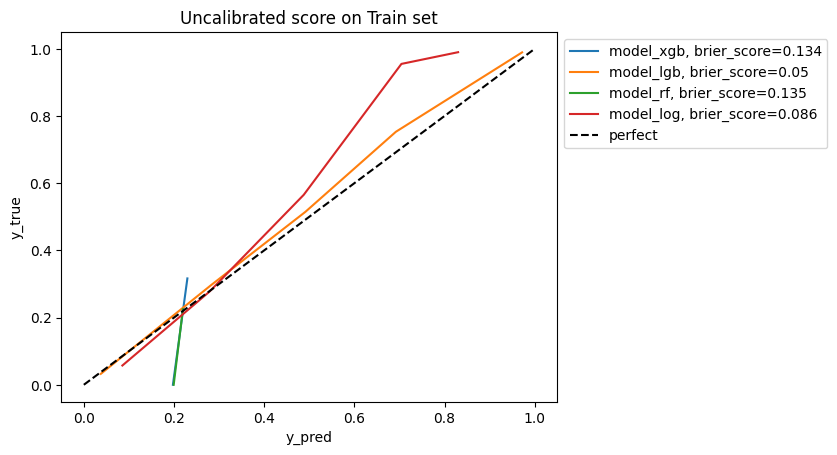

In [19]:
# Строим кривые надежности для классических неоткалиброванных моделей на тренировочном сете

fig = plt.figure()
for i, model in enumerate(models_ml):
    prob_true, prob_pred = calibration_curve(df_train[target_col], df_train[f'{names_ml[i]}_score'], n_bins=5)
    score = brier_score_loss(df_train[target_col], df_train[f'{names_ml[i]}_score'])
    plt.title('Uncalibrated score on Train set')
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_uncalib_train_ml.pdf')

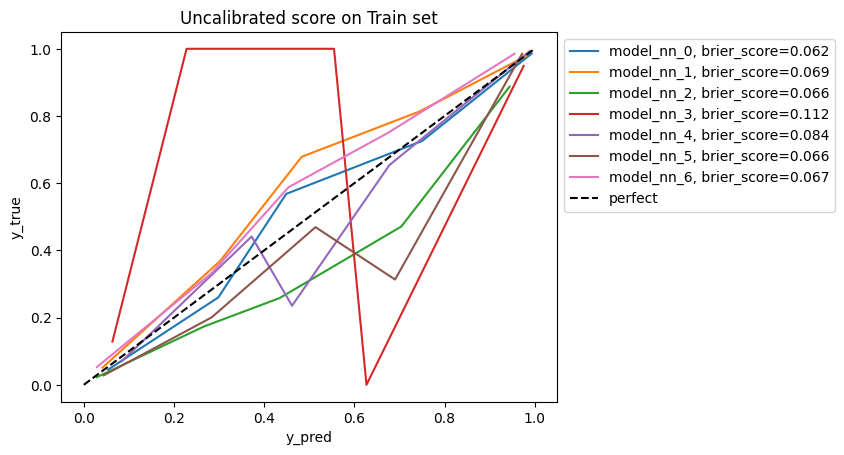

In [20]:
# Строим кривые надежности для неоткалиброванных нейронок на тренировочном сете

fig = plt.figure()
for i, model in enumerate(models_nn):
    prob_true, prob_pred = calibration_curve(df_train[target_col], df_train[f'{names_nn[i]}_score'], n_bins=5)
    score = brier_score_loss(df_train[target_col], df_train[f'{names_nn[i]}_score'])
    plt.title('Uncalibrated score on Train set')
    plt.plot(prob_pred, prob_true, label=f'{names_nn[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_uncalib_train_nn.pdf')

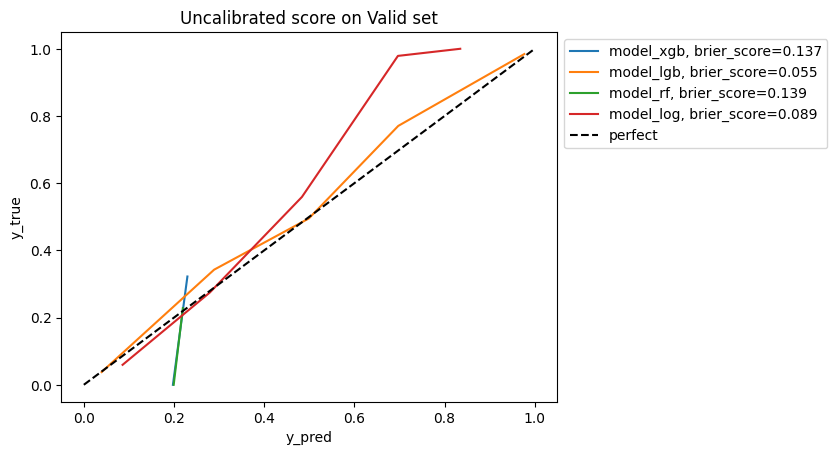

In [21]:
# Строим кривые надежности для классических неоткалиброванных моделей на валидационном сете

fig = plt.figure()
for i, model in enumerate(models_ml):
    prob_true, prob_pred = calibration_curve(df_valid[target_col], df_valid[f'{names_ml[i]}_score'], n_bins=5)
    score = brier_score_loss(df_valid[target_col], df_valid[f'{names_ml[i]}_score'])
    plt.title('Uncalibrated score on Valid set')
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_uncalib_valid_ml.pdf')

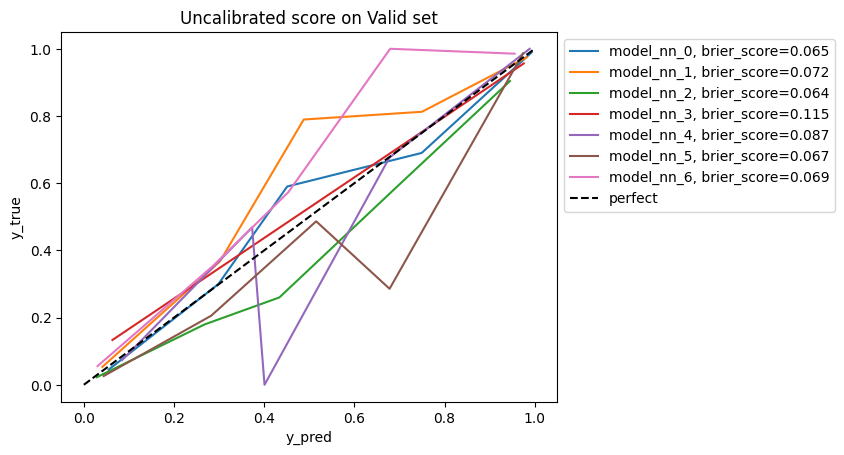

In [22]:
# Строим кривые надежности для неоткалиброванных нейронок на валидационном сете

fig = plt.figure()
for i, model in enumerate(models_nn):
    prob_true, prob_pred = calibration_curve(df_valid[target_col], df_valid[f'{names_nn[i]}_score'], n_bins=5)
    score = brier_score_loss(df_valid[target_col], df_valid[f'{names_nn[i]}_score'])
    plt.title('Uncalibrated score on Valid set')
    plt.plot(prob_pred, prob_true, label=f'{names_nn[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_uncalib_valid_nn.pdf')

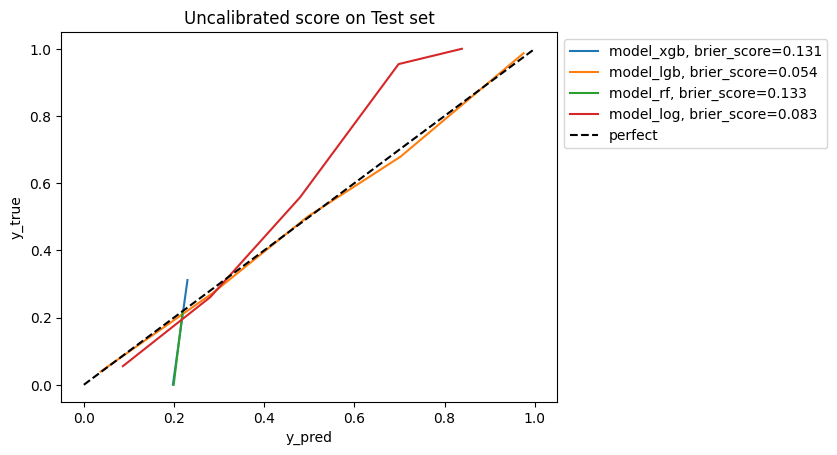

In [23]:
# Строим кривые надежности для классических неоткалиброванных моделей на тестовом сете

fig = plt.figure()
for i, model in enumerate(models_ml):
    prob_true, prob_pred = calibration_curve(df_test[target_col], df_test[f'{names_ml[i]}_score'], n_bins=5)
    score = brier_score_loss(df_test[target_col], df_test[f'{names_ml[i]}_score'])
    plt.title('Uncalibrated score on Test set')
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_uncalib_test_ml.pdf')

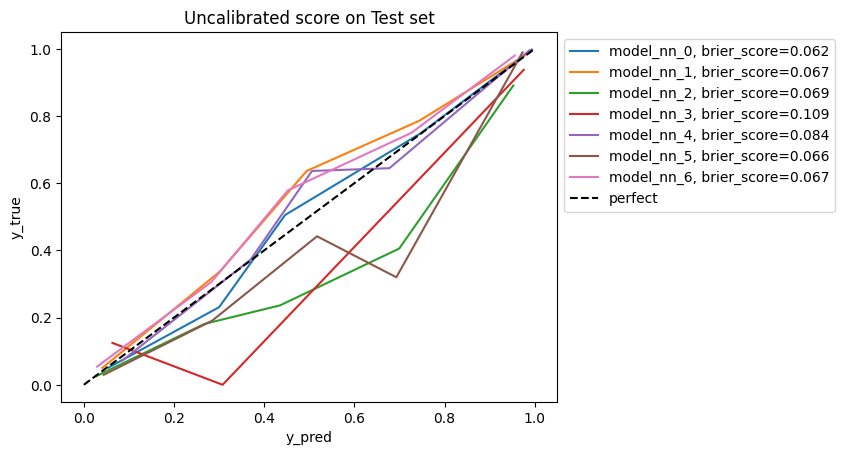

In [24]:
# Строим кривые надежности для неоткалиброванных нейронок на тестовом сете

fig = plt.figure()
for i, model in enumerate(models_nn):
    prob_true, prob_pred = calibration_curve(df_test[target_col], df_test[f'{names_nn[i]}_score'], n_bins=5)
    score = brier_score_loss(df_test[target_col], df_test[f'{names_nn[i]}_score'])
    plt.title('Uncalibrated score on Test set')
    plt.plot(prob_pred, prob_true, label=f'{names_nn[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_uncalib_test_nn.pdf')

__Строим кривые надежности для откалиброванных моделей методом Плата__

In [25]:
calibrators_ml = calibrators[:4] # Первые 4 калибратора относятся к классическим моделям
calibrators_nn = calibrators[4:] # Остальные калибраторы относятся к нейронкам

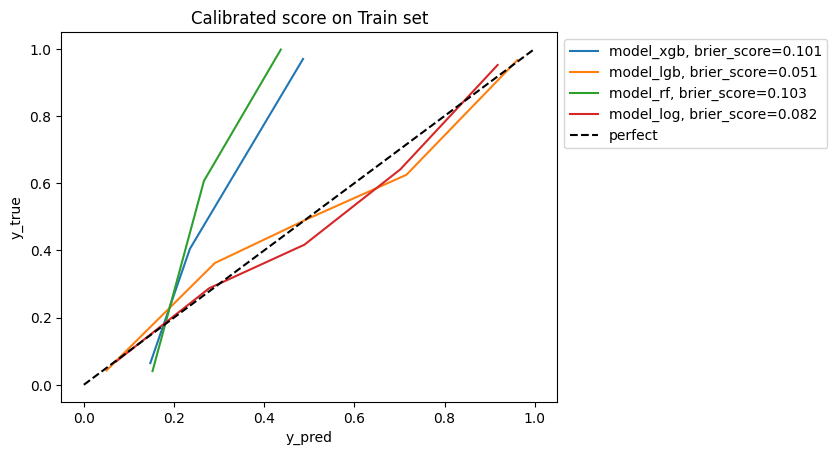

In [26]:
# Строим кривые надежности для классических откалиброванных моделей на тренировочном сете

fig = plt.figure()
for i, calibrator in enumerate(calibrators_ml):
    df_train[f'{names_ml[i]}_score_calib'] = calibrator.predict_proba(pd.DataFrame(df_train[f'{names_ml[i]}_score']))[:,1]
    prob_true, prob_pred = calibration_curve(df_train[target_col], df_train[f'{names_ml[i]}_score_calib'], n_bins=5)
    score = brier_score_loss(df_train[target_col], df_train[f'{names_ml[i]}_score_calib'])
    plt.title('Calibrated score on Train set')
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_train_ml.pdf')

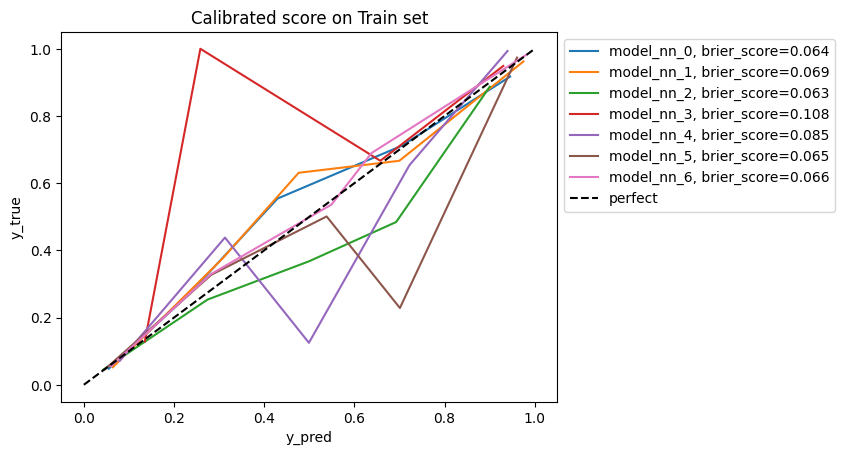

In [27]:
# Строим кривые надежности для откалиброванных нейронок на тренировочном сете

fig = plt.figure()
for i, calibrator in enumerate(calibrators_nn):
    df_train[f'{names_nn[i]}_score_calib'] = calibrator.predict_proba(pd.DataFrame(df_train[f'{names_nn[i]}_score']))[:,1]
    prob_true, prob_pred = calibration_curve(df_train[target_col], df_train[f'{names_nn[i]}_score_calib'], n_bins=5)
    score = brier_score_loss(df_train[target_col], df_train[f'{names_nn[i]}_score_calib'])
    plt.title('Calibrated score on Train set')
    plt.plot(prob_pred, prob_true, label=f'{names_nn[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_train_nn.pdf')

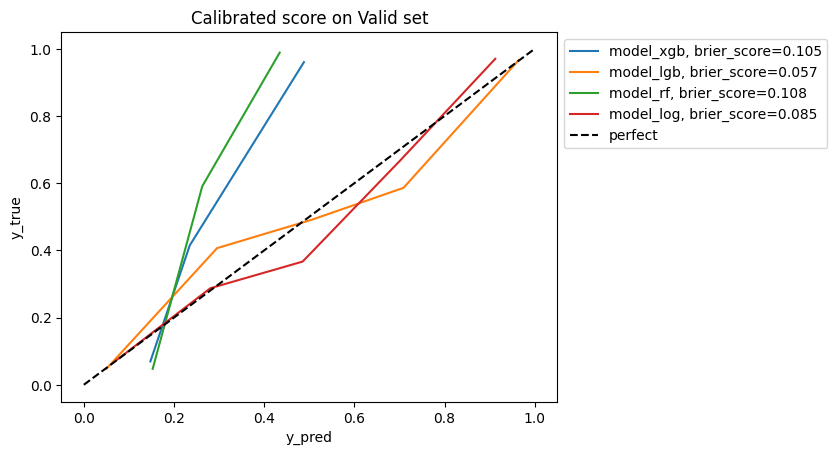

In [28]:
# Строим кривые надежности для классических откалиброванных моделей на валидационном сете

fig = plt.figure()
for i, calibrator in enumerate(calibrators_ml):
    df_valid[f'{names_ml[i]}_score_calib'] = calibrator.predict_proba(pd.DataFrame(df_valid[f'{names_ml[i]}_score']))[:,1]
    prob_true, prob_pred = calibration_curve(df_valid[target_col], df_valid[f'{names_ml[i]}_score_calib'], n_bins=5)
    score = brier_score_loss(df_valid[target_col], df_valid[f'{names_ml[i]}_score_calib'])
    plt.title('Calibrated score on Valid set')
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_valid_ml.pdf')

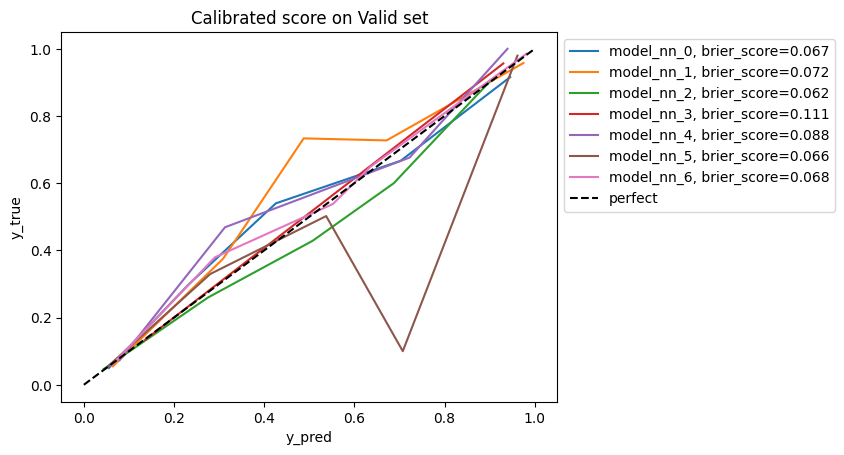

In [29]:
# Строим кривые надежности для откалиброванных нейронок на валидационном сете

fig = plt.figure()
for i, calibrator in enumerate(calibrators_nn):
    df_valid[f'{names_nn[i]}_score_calib'] = calibrator.predict_proba(pd.DataFrame(df_valid[f'{names_nn[i]}_score']))[:,1]
    prob_true, prob_pred = calibration_curve(df_valid[target_col], df_valid[f'{names_nn[i]}_score_calib'], n_bins=5)
    score = brier_score_loss(df_valid[target_col], df_valid[f'{names_nn[i]}_score_calib'])
    plt.title('Calibrated score on Valid set')
    plt.plot(prob_pred, prob_true, label=f'{names_nn[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_valid_nn.pdf')

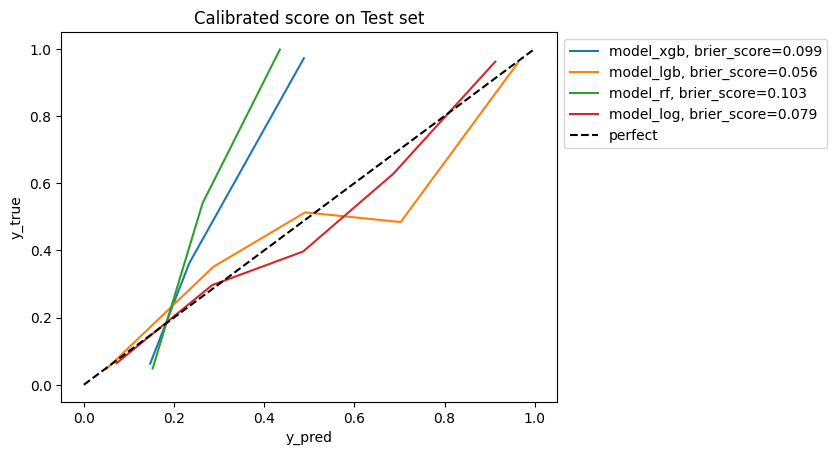

In [30]:
# Строим кривые надежности для классических откалиброванных моделей на тестовом сете

fig = plt.figure()
for i, calibrator in enumerate(calibrators_ml):
    df_test[f'{names_ml[i]}_score_calib'] = calibrator.predict_proba(pd.DataFrame(df_test[f'{names_ml[i]}_score']))[:,1]
    prob_true, prob_pred = calibration_curve(df_test[target_col], df_test[f'{names_ml[i]}_score_calib'], n_bins=5)
    score = brier_score_loss(df_test[target_col], df_test[f'{names_ml[i]}_score_calib'])
    plt.title('Calibrated score on Test set')
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_test_ml.pdf')

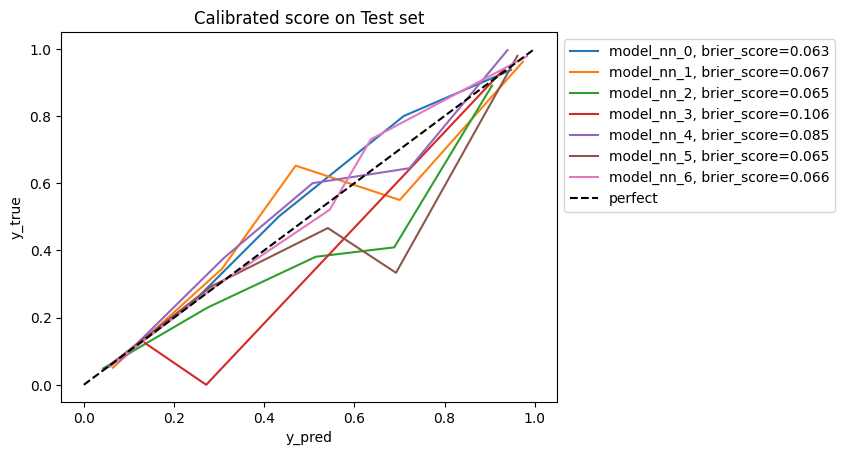

In [31]:
# Строим кривые надежности для откалиброванных нейронок на тестовом сете

fig = plt.figure()
for i, calibrator in enumerate(calibrators_nn):
    df_test[f'{names_nn[i]}_score_calib'] = calibrator.predict_proba(pd.DataFrame(df_test[f'{names_nn[i]}_score']))[:,1]
    prob_true, prob_pred = calibration_curve(df_test[target_col], df_test[f'{names_nn[i]}_score_calib'], n_bins=5)
    score = brier_score_loss(df_test[target_col], df_test[f'{names_nn[i]}_score_calib'])
    plt.title('Calibrated score on Test set')
    plt.plot(prob_pred, prob_true, label=f'{names_nn[i]}, brier_score={round(score, 3)}')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_test_nn.pdf')

## Калибровка классических моделей с применением стратифицированной кросс-валидации

Поскольку калибровка некоторых классических моделей МО методом Плата дала неудовлетворительные результаты, то было решено реализовать калибровку при помощи кросс-валидации

In [33]:
class Strat_kfold:
    """Калибраторы с использованием стратифицированной кросс-валидации"""
    
    def __init__(self, ml_model):
        self.model = ml_model
        self.calibrated_models = []
        self.average_probs_1 = []
        self.y_pred = []
        self.br_score = []
        
        # Создание экземпляра StratifiedKFold с указанием количества фолдов
        self.stratified_kfold = StratifiedKFold(n_splits=3, shuffle=False)
        
    def train(self, X_train, y_train, X_val, y_val):
        
        # Цикл по фолдам
        for train_idx, val_idx in stratified_kfold.split(X_train, y_train):
            # Разделение данных на обучающий и валидационный наборы
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Обучение модели на обучающем наборе
            try:
                self.model.set_params(early_stopping_rounds=75)
                self.model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)])
            except ValueError:
                self.model.fit(X_train_fold, y_train_fold)
                
            # Создание экземпляра CalibratedClassifierCV с методом калибровки и базовой моделью #sigmoid
            calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')

            # Калибровка модели на валидационном наборе
            calibrated_model.fit(X_train_fold, y_train_fold)

            # Добавление калиброванной модели в список
            self.calibrated_models.append(calibrated_model)
            
    def predict_proba(self, X_pred):
        
        #Получение усредненных предсказанных вероятностей от каждой калиброванной модели
        self.average_probs_1 = np.mean([calibrated_model.predict_proba(X_pred) for calibrated_model in self.calibrated_models], axis=0)
        
        return self.average_probs_1[:, 1]
    
    
    def predict(self, X_pred):
        self.predict_proba(X_pred)
        
        # Вычисление предсказанных меток на основе усредненных вероятностей
        self.y_pred = np.argmax(self.average_probs_1, axis=1)
                        
        return self.y_pred
    
    
    def get_average_probs(self):
        return self.average_probs_1[:, 1]

In [34]:
df_valid_1, df_valid_2 = train_test_split(df_valid, test_size=0.30, random_state=42) 

X_train =  df_valid_1[feature_columns]
y_train = df_valid_1[target_col]
X_val =  df_valid_2[feature_columns]
y_val = df_valid_2[target_col]

calibrators_ml_kfold = []
for i, model in enumerate(models_all[:4]):
    calibrator = Strat_kfold(model)
    calibrator.train(X_train, y_train, X_val, y_val)
    calibrators_ml_kfold.append(calibrator)

[0]	validation_0-logloss:0.43204	validation_0-roc_auc_score:0.91744
[0]	validation_0-logloss:0.43074	validation_0-roc_auc_score:0.91766
[0]	validation_0-logloss:0.43600	validation_0-roc_auc_score:0.91609
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Info] Number of positive: 253, number of negative: 1155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 9
[LightGBM] [Warning] early_stopping_round is set=75, early_stopping_rounds=75 will be ignored. Current value: early_stopping_round=75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179688 -> initscore=-1.518466
[LightGBM] [Info] Start training from score -1.518466
Training until validation scores don't i

Brier Score: 0.07373788504858603
Brier Score: 0.06317546781514848
Brier Score: 0.06259109572431362
Brier Score: 0.08441971512355217


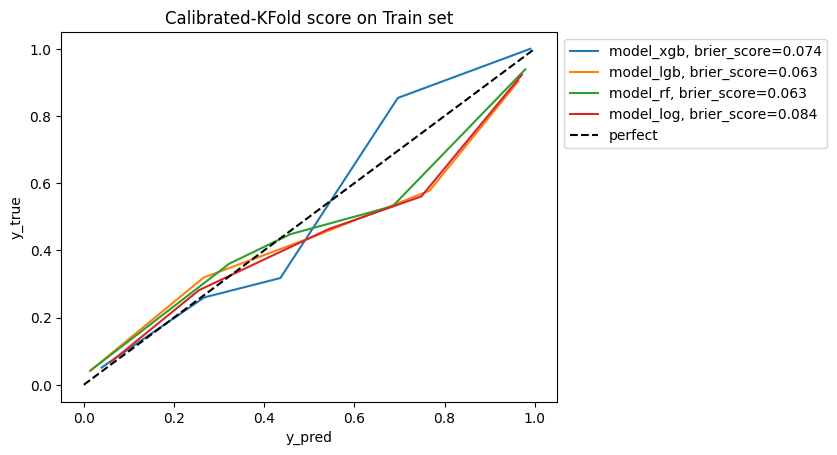

In [35]:
fig = plt.figure()
for i, calibrated_model in enumerate(calibrators_ml_kfold):
    y_pred_prob = calibrated_model.predict_proba(df_train[feature_columns])
    # Вычисление Brier Score
    score = brier_score_loss(df_train[target_col], calibrated_model.get_average_probs())
    print("Brier Score:", score)
    y_true = df_train[target_col]

    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=5)
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
    
plt.title('Calibrated-KFold score on Train set')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_train_KFold_ml.pdf')

Brier Score: 0.07254020984457211
Brier Score: 0.05476473787040317
Brier Score: 0.0510865540636223
Brier Score: 0.08349970086426492


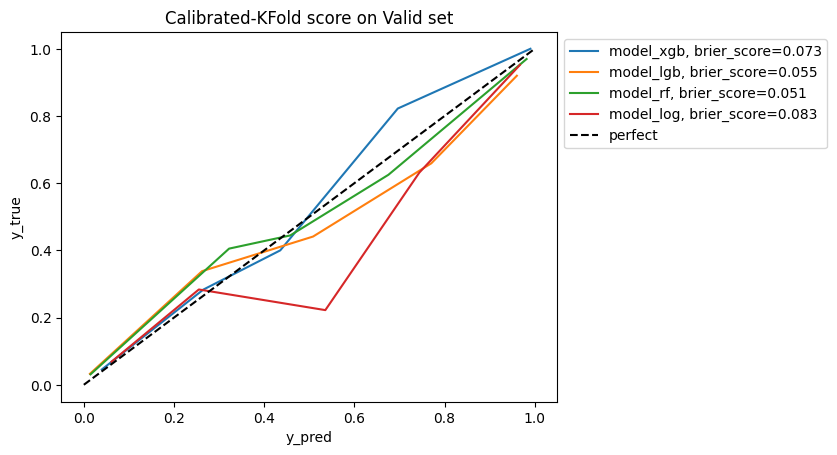

In [36]:
fig = plt.figure()
for i, calibrated_model in enumerate(calibrators_ml_kfold):
    y_pred_prob = calibrated_model.predict_proba(df_valid[feature_columns])
    # Вычисление Brier Score
    score = brier_score_loss(df_valid[target_col], calibrated_model.get_average_probs())
    print("Brier Score:", score)
    y_true = df_valid[target_col]

    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=5)
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
    
plt.title('Calibrated-KFold score on Valid set')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_validt_KFold_ml.pdf')

Brier Score: 0.07260395412004905
Brier Score: 0.06575204385317146
Brier Score: 0.06707819686254878
Brier Score: 0.08075170164379775


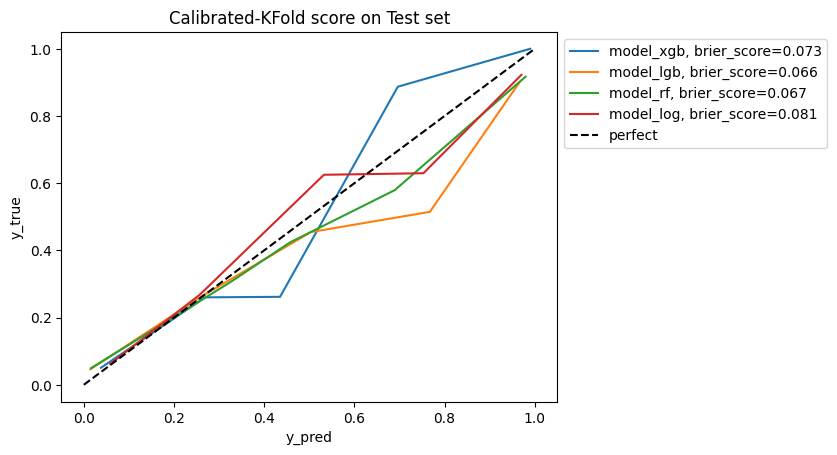

In [37]:
fig = plt.figure()
for i, calibrated_model in enumerate(calibrators_ml_kfold):
    y_pred_prob = calibrated_model.predict_proba(df_test[feature_columns])
    # Вычисление Brier Score
    score = brier_score_loss(df_test[target_col], calibrated_model.get_average_probs())
    print("Brier Score:", score)
    y_true = df_test[target_col]

    prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=5)
    plt.plot(prob_pred, prob_true, label=f'{names_ml[i]}, brier_score={round(score, 3)}')
    
plt.title('Calibrated-KFold score on Test set')
plt.plot([0, 1], [0, 1], '--', color='black', label='perfect')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel('y_pred')
plt.ylabel('y_true')
fig.savefig('reliability_curve_calib_test_KFold_ml.pdf')

In [38]:
# Подсчитываем метрики калибраторов и добавляем в датафрейм

for i, calibrator in enumerate(calibrators_ml_kfold):

    preds_train = calibrator.predict_proba(df_train[feature_columns])
    preds_valid = calibrator.predict_proba(df_valid[feature_columns])
    preds_test = calibrator.predict_proba(df_test[feature_columns])

    labels_train = calibrator.predict(df_train[feature_columns])
    labels_valid = calibrator.predict(df_valid[feature_columns])
    labels_test = calibrator.predict(df_test[feature_columns])

    row = [
        #f'{names[i]}_calibrated',
        log_loss(df_train[target_col], preds_train),
        log_loss(df_valid[target_col], preds_valid),
        log_loss(df_test[target_col], preds_test),
        accuracy_score(df_train[target_col], labels_train),
        accuracy_score(df_valid[target_col], labels_valid),
        accuracy_score(df_test[target_col], labels_test),
        roc_auc_score(df_train[target_col], preds_train),
        roc_auc_score(df_valid[target_col], preds_valid),
        roc_auc_score(df_test[target_col], preds_test),
    ]
    row = [round(j, 3) if j is not None and type(j) != str else j for j in row]

    df_metrics.loc[f'{names[i]}_calibrated_kfold'] = row

#### Сохранение полученных результатов

In [39]:
# Сохранение калибраторов ML

with open('models/calibrator_xgb.pkl','wb') as f:
    pickle.dump(calibrators_ml[0], f)
with open('models/calibrator_lgb.pkl','wb') as f:
    pickle.dump(calibrators_ml[1], f)
with open('models/calibrator_rf.pkl','wb') as f:
    pickle.dump(calibrators_ml[2], f)
with open('models/calibrator_log.pkl','wb') as f:
    pickle.dump(calibrators_ml[3], f)

In [40]:
# Сохранение калибраторов NN

for i, calibrator in enumerate(calibrators_nn):
    with open(f'models/calibrator_nn_{i}.pkl','wb') as f:
        pickle.dump(calibrator, f)

In [41]:
# Сохранение калибраторов ML- K-fold

with open('models/calibrator_kfold_xgb.pkl','wb') as f:
    pickle.dump(calibrators_ml_kfold[0], f)
with open('models/calibrator_kfold_lgb.pkl','wb') as f:
    pickle.dump(calibrators_ml_kfold[1], f)
with open('models/calibrator_kfold_rf.pkl','wb') as f:
    pickle.dump(calibrators_ml_kfold[2], f)
with open('models/calibrator_kfold_log.pkl','wb') as f:
    pickle.dump(calibrators_ml_kfold[3], f)